In [10]:
# import
import numpy
import matplotlib.pyplot
import torch
import torch.nn.functional
import torch.utils.data

In [11]:
# variables
# Dataset(1080) should be divisible by BATCH_SIZE
BATCH_SIZE = 64
LEARNING_RATE = 0.004
EPOCH = 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

REMIDER = 50
TIMES = 6
# matplotlib set
COLOR = ['#FF0000', '#00FF00', '#0000FF', '#880000', '#008800', '#000088']
LABEL = [
    'Train_ELU', 'Train_ReLU', 'Train_LeakyReLU', 'Test_ELU', 'Test_ReLU',
    'Test_LeakyReLU'
]

In [12]:
# function
# load data from .npz
def read_bci_data():
    S4b_train = numpy.load('S4b_train.npz')
    X11b_train = numpy.load('X11b_train.npz')
    S4b_test = numpy.load('S4b_test.npz')
    X11b_test = numpy.load('X11b_test.npz')

    train_data = numpy.concatenate((S4b_train['signal'], X11b_train['signal']),
                                   axis=0)
    train_label = numpy.concatenate((S4b_train['label'], X11b_train['label']),
                                    axis=0)
    test_data = numpy.concatenate((S4b_test['signal'], X11b_test['signal']),
                                  axis=0)
    test_label = numpy.concatenate((S4b_test['label'], X11b_test['label']),
                                   axis=0)

    train_label = train_label - 1
    test_label = test_label - 1
    train_data = numpy.transpose(
        numpy.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = numpy.transpose(
        numpy.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = numpy.where(numpy.isnan(train_data))
    train_data[mask] = numpy.nanmean(train_data)

    mask = numpy.where(numpy.isnan(test_data))
    test_data[mask] = numpy.nanmean(test_data)

    #     print(train_data.shape, train_label.shape, test_data.shape,
    #           test_label.shape)

    return train_data, train_label, test_data, test_label


# plot channel
# only plot 1 data (2 channels) at a time
def plotChannel(inputs, name, color):
    matplotlib.pyplot.figure(figsize=(15, 5))
    matplotlib.pyplot.plot(inputs, label=name, color=color)
    matplotlib.pyplot.legend(loc='best')
    matplotlib.pyplot.show()
    matplotlib.pyplot.clf()

In [13]:
# module(EEG Net)
class EEGNet_ELU(torch.nn.Module):
    def __init__(self):
        super(EEGNet_ELU, self).__init__()
        self.firstconv = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=(1, 51),
                stride=(1, 1),
                padding=(0, 25),
                bias=False),
            torch.nn.BatchNorm2d(
                num_features=16,
                eps=0.00001,
                momentum=0.1,
                affine=True,
                track_running_stats=True))
        self.depthwiseConv = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=(2, 1),
                stride=(1, 1),
                groups=16,
                bias=False),
            torch.nn.BatchNorm2d(
                num_features=32,
                eps=0.00001,
                momentum=0.1,
                affine=True,
                track_running_stats=True), torch.nn.ELU(alpha=1.0),
            torch.nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            torch.nn.Dropout(p=0.25))
        self.separableConv = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=(1, 15),
                stride=(1, 1),
                padding=(0, 7),
                bias=False),
            torch.nn.BatchNorm2d(
                num_features=32,
                eps=0.00001,
                momentum=0.1,
                affine=True,
                track_running_stats=True), torch.nn.ELU(alpha=1.0),
            torch.nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            torch.nn.Dropout(p=0.25))
        self.classify = torch.nn.Sequential(
            torch.nn.Linear(in_features=736, out_features=2, bias=True))

    def forward(self, x):
        # a torch.Size([BATCH_SIZE, 1, 2, 750])
        x = self.firstconv(x)
        # b torch.Size([BATCH_SIZE, 16, 2, 750])
        x = self.depthwiseConv(x)
        # c torch.Size([BATCH_SIZE, 32, 1, 187])
        x = self.separableConv(x)
        # d torch.Size([BATCH_SIZE, 32, 1, 23])

        x = x.view(-1, 736)
        # e torch.Size([BATCH_SIZE, 736])

        x = self.classify(x)
        # f torch.Size([BATCH_SIZE, 2])

        return x


class EEGNet_ReLU(torch.nn.Module):
    def __init__(self):
        super(EEGNet_ReLU, self).__init__()
        self.firstconv = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=(1, 51),
                stride=(1, 1),
                padding=(0, 25),
                bias=False),
            torch.nn.BatchNorm2d(
                num_features=16,
                eps=0.00001,
                momentum=0.1,
                affine=True,
                track_running_stats=True))
        self.depthwiseConv = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=(2, 1),
                stride=(1, 1),
                groups=16,
                bias=False),
            torch.nn.BatchNorm2d(
                num_features=32,
                eps=0.00001,
                momentum=0.1,
                affine=True,
                track_running_stats=True), torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            torch.nn.Dropout(p=0.25))
        self.separableConv = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=(1, 15),
                stride=(1, 1),
                padding=(0, 7),
                bias=False),
            torch.nn.BatchNorm2d(
                num_features=32,
                eps=0.00001,
                momentum=0.1,
                affine=True,
                track_running_stats=True), torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            torch.nn.Dropout(p=0.25))
        self.classify = torch.nn.Sequential(
            torch.nn.Linear(in_features=736, out_features=2, bias=True))

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(-1, 736)
        x = self.classify(x)

        return x


class EEGNet_LeakyReLU(torch.nn.Module):
    def __init__(self):
        super(EEGNet_LeakyReLU, self).__init__()
        self.firstconv = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=(1, 51),
                stride=(1, 1),
                padding=(0, 25),
                bias=False),
            torch.nn.BatchNorm2d(
                num_features=16,
                eps=0.00001,
                momentum=0.1,
                affine=True,
                track_running_stats=True))
        self.depthwiseConv = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=(2, 1),
                stride=(1, 1),
                groups=16,
                bias=False),
            torch.nn.BatchNorm2d(
                num_features=32,
                eps=0.00001,
                momentum=0.1,
                affine=True,
                track_running_stats=True), torch.nn.LeakyReLU(),
            torch.nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            torch.nn.Dropout(p=0.25))
        self.separableConv = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=(1, 15),
                stride=(1, 1),
                padding=(0, 7),
                bias=False),
            torch.nn.BatchNorm2d(
                num_features=32,
                eps=0.00001,
                momentum=0.1,
                affine=True,
                track_running_stats=True), torch.nn.LeakyReLU(),
            torch.nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            torch.nn.Dropout(p=0.25))
        self.classify = torch.nn.Sequential(
            torch.nn.Linear(in_features=736, out_features=2, bias=True))

    def forward(self, x):
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(-1, 736)
        x = self.classify(x)

        return x

In [14]:
# module(Deep Conv Net)
class DeepConvNet_ELU(torch.nn.Module):
    def __init__(self):
        super(DeepConvNet_ELU, self).__init__()
        self.Conv2d_1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1, out_channels=25, kernel_size=(1, 5)))
        self.Conv2d_2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=25, out_channels=25, kernel_size=(2, 1)),
            torch.nn.BatchNorm2d(num_features=25, eps=0.00001, momentum=0.1),
            torch.nn.ELU(), torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5))
        self.Conv2d_3 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=25, out_channels=50, kernel_size=(1, 5)),
            torch.nn.BatchNorm2d(num_features=50, eps=0.00001, momentum=0.1),
            torch.nn.ELU(), torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5))
        self.Conv2d_4 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=50, out_channels=100, kernel_size=(1, 5)),
            torch.nn.BatchNorm2d(num_features=100, eps=0.00001, momentum=0.1),
            torch.nn.ELU(), torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5))
        self.Conv2d_5 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=100, out_channels=200, kernel_size=(1, 5)),
            torch.nn.BatchNorm2d(num_features=200, eps=0.00001, momentum=0.1),
            torch.nn.ELU(), torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5))
        # CrossEntropy couldn't add softmax
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(in_features=200 * 1 * 43, out_features=2))

    def forward(self, x):
        # a torch.Size([BATCH_SIZE, 1, 2, 750])

        x = self.Conv2d_1(x)
        # b torch.Size([BATCH_SIZE, 25, 2, 746])

        x = self.Conv2d_2(x)
        # c torch.Size([BATCH_SIZE, 25, 1, 373])

        x = self.Conv2d_3(x)
        # d torch.Size([BATCH_SIZE, 50, 1, 184])

        x = self.Conv2d_4(x)
        # e torch.Size([BATCH_SIZE, 100, 1, 90])

        x = self.Conv2d_5(x)
        # f torch.Size([BATCH_SIZE, 200, 1, 43])

        x = x.view(-1, 200 * 1 * 43)
        # g torch.Size([BATCH_SIZE, 200 * 1 * 43])

        x = self.dense(x)
        # i torch.Size([BATCH_SIZE, 2])

        return x


class DeepConvNet_ReLU(torch.nn.Module):
    def __init__(self):
        super(DeepConvNet_ReLU, self).__init__()
        self.Conv2d_1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1, out_channels=25, kernel_size=(1, 5)))
        self.Conv2d_2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=25, out_channels=25, kernel_size=(2, 1)),
            torch.nn.BatchNorm2d(num_features=25, eps=0.00001, momentum=0.1),
            torch.nn.ReLU(), torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5))
        self.Conv2d_3 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=25, out_channels=50, kernel_size=(1, 5)),
            torch.nn.BatchNorm2d(num_features=50, eps=0.00001, momentum=0.1),
            torch.nn.ReLU(), torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5))
        self.Conv2d_4 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=50, out_channels=100, kernel_size=(1, 5)),
            torch.nn.BatchNorm2d(num_features=100, eps=0.00001, momentum=0.1),
            torch.nn.ReLU(), torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5))
        self.Conv2d_5 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=100, out_channels=200, kernel_size=(1, 5)),
            torch.nn.BatchNorm2d(num_features=200, eps=0.00001, momentum=0.1),
            torch.nn.ReLU(), torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5))
        # CrossEntropy couldn't add softmax
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(in_features=200 * 1 * 43, out_features=2))

    def forward(self, x):
        x = self.Conv2d_1(x)
        x = self.Conv2d_2(x)
        x = self.Conv2d_3(x)
        x = self.Conv2d_4(x)
        x = self.Conv2d_5(x)
        x = x.view(-1, 200 * 1 * 43)
        x = self.dense(x)

        return x


class DeepConvNet_LeakyReLU(torch.nn.Module):
    def __init__(self):
        super(DeepConvNet_LeakyReLU, self).__init__()
        self.Conv2d_1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1, out_channels=25, kernel_size=(1, 5)))
        self.Conv2d_2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=25, out_channels=25, kernel_size=(2, 1)),
            torch.nn.BatchNorm2d(num_features=25, eps=0.00001, momentum=0.1),
            torch.nn.LeakyReLU(), torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5))
        self.Conv2d_3 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=25, out_channels=50, kernel_size=(1, 5)),
            torch.nn.BatchNorm2d(num_features=50, eps=0.00001, momentum=0.1),
            torch.nn.LeakyReLU(), torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5))
        self.Conv2d_4 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=50, out_channels=100, kernel_size=(1, 5)),
            torch.nn.BatchNorm2d(num_features=100, eps=0.00001, momentum=0.1),
            torch.nn.LeakyReLU(), torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5))
        self.Conv2d_5 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=100, out_channels=200, kernel_size=(1, 5)),
            torch.nn.BatchNorm2d(num_features=200, eps=0.00001, momentum=0.1),
            torch.nn.LeakyReLU(), torch.nn.MaxPool2d(kernel_size=(1, 2)),
            torch.nn.Dropout(p=0.5))
        # CrossEntropy couldn't add softmax
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(in_features=200 * 1 * 43, out_features=2))

    def forward(self, x):
        x = self.Conv2d_1(x)
        x = self.Conv2d_2(x)
        x = self.Conv2d_3(x)
        x = self.Conv2d_4(x)
        x = self.Conv2d_5(x)
        x = x.view(-1, 200 * 1 * 43)
        x = self.dense(x)

        return x

In [15]:
# produce data
# load data
trainData, trainLabel, testData, testLabel = read_bci_data()
# convert data from numpy.ndarray to double torch.Tensor, and sent data to GPU
trainData = torch.from_numpy(trainData).type(torch.cuda.FloatTensor).to(device)
trainLabel = torch.from_numpy(trainLabel).type(
    torch.cuda.FloatTensor).to(device)
testData = torch.from_numpy(testData).type(torch.cuda.FloatTensor).to(device)
testLabel = torch.from_numpy(testLabel).type(torch.cuda.FloatTensor).to(device)

# dataset & dataloader
trainDataset = torch.utils.data.TensorDataset(trainData, trainLabel)
testDataset = torch.utils.data.TensorDataset(testData, testLabel)
trainDataLoader = torch.utils.data.DataLoader(
    trainDataset, batch_size=BATCH_SIZE, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(
    testDataset, batch_size=BATCH_SIZE, shuffle=False)

TIMES: 0 ( EEGNet_ELU )
EPOCH: 0
Training Loss	 tensor(0.6979, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.6718, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.5951, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.5450, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.5419, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.6918, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.6458, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.5386, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.5582, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.6212, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.6176, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.5577, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.5892, device='cuda:0', grad_fn=<NllLossBackward>)
Train

EPOCH: 200
Training Loss	 tensor(0.0786, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0577, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0230, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1175, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0494, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0663, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0448, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0718, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0423, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0340, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0433, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0138, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1336, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.086

EPOCH: 400
Training Loss	 tensor(0.0216, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0390, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0184, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0826, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0124, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0706, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0832, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0073, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0434, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0056, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.011

EPOCH: 100
Training Loss	 tensor(0.0177, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0255, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0253, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0888, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1310, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0254, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0367, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0414, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0470, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0192, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0250, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0217, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.028

EPOCH: 300
Training Loss	 tensor(0.0920, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0166, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0078, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0058, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0678, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0216, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0050, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0151, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0066, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0133, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0052, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.003

TIMES: 2 ( EEGNet_LeakyReLU )
EPOCH: 0
Training Loss	 tensor(0.7131, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.7966, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.7522, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.6601, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.6542, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.6364, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.6054, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.5353, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.6058, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.6401, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.5918, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.5844, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.5857, device='cuda:0', grad_fn=<NllLossBackward>)

EPOCH: 200
Training Loss	 tensor(0.0510, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0132, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0070, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0501, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0395, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0493, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0567, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0148, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0185, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0203, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0313, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0508, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0576, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.016

EPOCH: 400
Training Loss	 tensor(0.0128, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0082, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0253, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0056, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0097, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0482, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0155, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0049, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0077, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0075, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.027

EPOCH: 100
Training Loss	 tensor(0.0454, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1267, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1910, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2007, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1194, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2851, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2868, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2036, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0480, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1457, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0576, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0988, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0873, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.132

EPOCH: 300
Training Loss	 tensor(0.0309, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0108, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0600, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0886, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0210, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0064, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1013, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0059, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0175, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0888, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0153, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2739, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0585, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.023

TIMES: 4 ( DeepConvNet_ReLU )
EPOCH: 0
Training Loss	 tensor(0.7626, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(3.5368, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(1.2292, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.8688, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.8885, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(1.0854, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(1.1308, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.9959, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.8559, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(1.0285, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.8262, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.9350, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.8878, device='cuda:0', grad_fn=<NllLossBackward>)

EPOCH: 200
Training Loss	 tensor(0.0675, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1205, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0429, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2005, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0498, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1356, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1258, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0982, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1455, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1803, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0866, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0612, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1234, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.052

EPOCH: 400
Training Loss	 tensor(0.0544, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2087, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1914, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0966, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0475, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0649, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1858, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0319, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0590, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0782, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0845, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1204, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1177, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.105

EPOCH: 100
Training Loss	 tensor(0.1702, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2448, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2585, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1604, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2223, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2203, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2140, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2142, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2316, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2544, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.3414, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2226, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2625, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.299

EPOCH: 300
Training Loss	 tensor(0.0766, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1868, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1006, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2208, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1785, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0744, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1919, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.2131, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1460, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0636, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.1702, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0889, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.0825, device='cuda:0', grad_fn=<NllLossBackward>)
Training Loss	 tensor(0.085

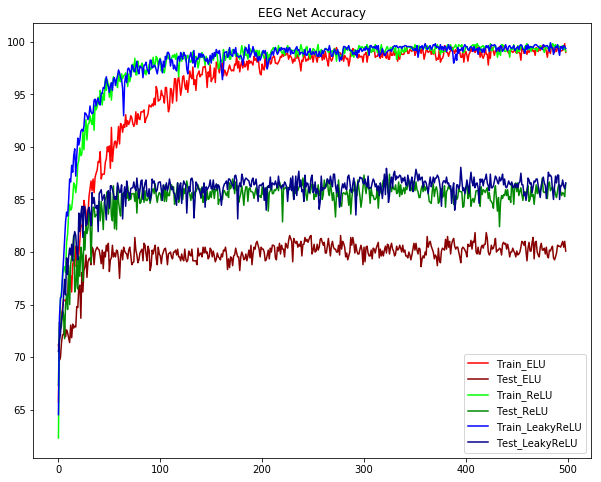

<Figure size 432x288 with 0 Axes>

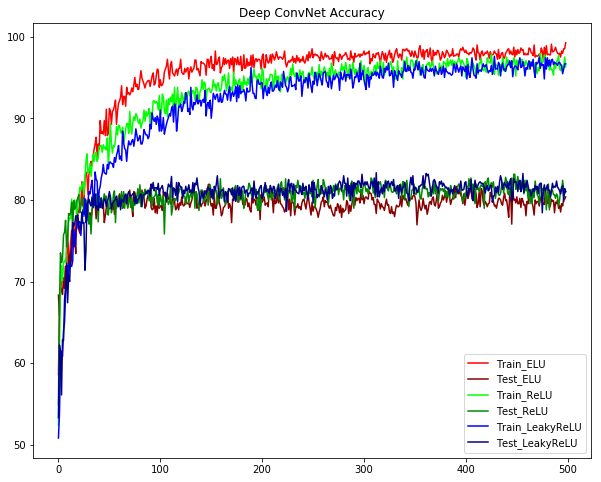

EEG Net Test_ELU 81.85185185185185
EEG Net Test_ReLU 87.4074074074074
EEG Net Test_LeakyReLU 88.05555555555556
Deep ConvNet Test_ELU 81.94444444444444
Deep ConvNet Test_ReLU 83.14814814814815
Deep ConvNet Test_LeakyReLU 83.33333333333334


<Figure size 432x288 with 0 Axes>

In [9]:
# Lab2
# fixed random parameter
torch.manual_seed(0)
# traning & testing
trainAccuracyArray = []
testAccuracyArray = []
for times in range(TIMES):
    # create network
    if (times == 0):
        module = EEGNet_ELU().to(device)
    elif (times == 1):
        module = EEGNet_ReLU().to(device)
    elif (times == 2):
        module = EEGNet_LeakyReLU().to(device)
    elif (times == 3):
        module = DeepConvNet_ELU().to(device)
    elif (times == 4):
        module = DeepConvNet_ReLU().to(device)
    elif (times == 5):
        module = DeepConvNet_LeakyReLU().to(device)

    optimizer = torch.optim.Adam(
        module.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    criterion = torch.nn.CrossEntropyLoss()

    print('TIMES:', times, '(', module.__class__.__name__, ')')

    for epoch in range(EPOCH):
        if epoch % REMIDER == 0:
            print('EPOCH:', epoch)

        # training
        module = module.train()
        trainCorrect = 0
        for i, (data, label) in enumerate(trainDataLoader):
            data.requires_grad = True
            optimizer.zero_grad()

            # forward
            output = module(data).to(device)

            # predict
            preds = output.argmax(dim=1).type(
                torch.cuda.FloatTensor).to(device)
            trainCorrect += (preds == label).sum().item()

            # loss & backpropagation
            trainLoss = criterion(output, label.long())
            if epoch % REMIDER == 0:
                print('Training Loss\t', trainLoss)
                pass
            trainLoss.backward()
            optimizer.step()

        trainAccuracyArray.append(
            (trainCorrect / len(trainDataLoader.dataset)) * 100)

        # testing
        module = module.eval()
        testCorrect = 0
        with torch.no_grad():
            for i, (data, label) in enumerate(testDataLoader):
                output = module(data).to(device)

                # predict
                preds = output.argmax(dim=1).type(
                    torch.cuda.FloatTensor).to(device)
                testCorrect += (preds == label).sum().item()

                # loss
                testLoss = criterion(output, label.long())
                if epoch % REMIDER == 0:
                    print('Testing Loss\t', testLoss)
                    pass

        testAccuracyArray.append(
            (testCorrect / len(testDataLoader.dataset)) * 100)

# reset module
    del module

# show result plot
matplotlib.pyplot.figure(figsize=(10, 8))
for times in range(0, 3):
    matplotlib.pyplot.plot(
        trainAccuracyArray[times * EPOCH:(times + 1) * EPOCH - 1],
        label=LABEL[times],
        color=COLOR[times])
    matplotlib.pyplot.plot(
        testAccuracyArray[times * EPOCH:(times + 1) * EPOCH - 1],
        label=LABEL[times + 3],
        color=COLOR[times + 3])
matplotlib.pyplot.title('EEG Net Accuracy')
matplotlib.pyplot.legend(loc='best')
matplotlib.pyplot.show()
matplotlib.pyplot.clf()
matplotlib.pyplot.figure(figsize=(10, 8))
for times in range(3, 6):
    matplotlib.pyplot.plot(
        trainAccuracyArray[times * EPOCH:(times + 1) * EPOCH - 1],
        label=LABEL[times - 3],
        color=COLOR[times - 3])
    matplotlib.pyplot.plot(
        testAccuracyArray[times * EPOCH:(times + 1) * EPOCH - 1],
        label=LABEL[times],
        color=COLOR[times])
matplotlib.pyplot.title('Deep ConvNet Accuracy')
matplotlib.pyplot.legend(loc='best')
matplotlib.pyplot.show()
matplotlib.pyplot.clf()

# show highest accuracy
for times in range(0, 3):
    print('EEG Net', LABEL[times + 3],
          max(testAccuracyArray[times * EPOCH:times * EPOCH + (EPOCH - 1)]))
for times in range(3, 6):
    print('Deep ConvNet', LABEL[times],
          max(testAccuracyArray[times * EPOCH:times * EPOCH + (EPOCH - 1)]))